In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

---

<h1><center>SDSE Homework 5 <br><br> Neural networks for time series forecasting </center></h1>

---

In this homework we will build a model to forecast the intensity of traffic flow on a freeway over the coming 24 hours, based on measurements of traffic flow intensity over the past six hours. The data was obtained from Caltrans' Performance Measurement System ([PeMS](https://pems.dot.ca.gov/)). This site archives 5-minute average flow and speed measurements taken from sensors embedded in the pavement, at approximately 1-mile intervals, on freeways across the state. We will focus on measurements from a particular sensor, taken between January 2018 and October 2019. 

We will compare three neural network architectures: a dense neural network with multiple input and output channels, a simple recurrent neural network, and an LSTM network. We will use Keras and Tensorflow to build and train these models. Use `pip` to install these packages in your Python environment.

``` 
pip install tensorflow
pip install keras
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten
keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

# 0. Load the data

Use `pd.read_csv` to load the CSV file `'traffic_flows.csv'` data into a pandas DataFrame called `rawdata`.

In [3]:
rawdata = pd.read_csv('traffic_flows.csv')

In [4]:
grader.check("q0")

q0 results: All test cases passed!

Notice that we have a total of 13,980 data samples, ranging from January 1st, 2018 to October 26th, 2019. The following table tells us that the `DateAndTime` column is string-valued, while the `Total Flow` column contains numbers.

In [5]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13980 entries, 0 to 13979
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateAndTime  13980 non-null  object 
 1   Flow         13980 non-null  float64
dtypes: float64(1), object(1)
memory usage: 218.6+ KB


## 1. Convert the DateAndTime column to type Timestamp

To enable pandas' time series features, we must convert the `DateAndTime` information from a strings into `Timestamp` objects. Use pandas' [`to_datetime`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) method to do this. Pass the `DateAndTime` column of `rawdata` into this method, and store the result in a new column called 'DateAndTimeTS'

In [6]:
rawdata['DateAndTimeTS'] = pd.to_datetime(rawdata['DateAndTime'])

In [7]:
rawdata.head()

,DateAndTime,Flow,DateAndTimeTS
0,01/01/2018 00:00:00,3637.0,2018-01-01 00:00:00
1,01/01/2018 01:00:00,3955.0,2018-01-01 01:00:00
2,01/01/2018 02:00:00,3464.0,2018-01-01 02:00:00
3,01/01/2018 03:00:00,2810.0,2018-01-01 03:00:00
4,01/01/2018 04:00:00,2659.0,2018-01-01 04:00:00


In [8]:
grader.check("q1")

q1 results: All test cases passed!

## 2. Use the `DateAndTimeTS` as the index

The [`set_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html) method of `rawdata` returns a new table with the given column as its index. Pass the string 'DataAndTimeTS' into this method and store the result in `data1`.

In [9]:
data1 = rawdata.set_index('DateAndTimeTS') 

In [10]:
data1.head()

,DateAndTime,Flow
DateAndTimeTS,,
2018-01-01 00:00:00,01/01/2018 00:00:00,3637.0
2018-01-01 01:00:00,01/01/2018 01:00:00,3955.0
2018-01-01 02:00:00,01/01/2018 02:00:00,3464.0
2018-01-01 03:00:00,01/01/2018 03:00:00,2810.0
2018-01-01 04:00:00,01/01/2018 04:00:00,2659.0


In [11]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Drop the `DateAndTime` column

The `DateAndTime` column is now superfluous. Use the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method applied to `data1` with the `columns` argument to remove this column. Store the result in `data2`.

In [12]:
data2 = data1.drop(['DateAndTime'], axis=1) 

In [13]:
data2.head()

,Flow
DateAndTimeTS,
2018-01-01 00:00:00,3637.0
2018-01-01 01:00:00,3955.0
2018-01-01 02:00:00,3464.0
2018-01-01 03:00:00,2810.0
2018-01-01 04:00:00,2659.0


In [14]:
grader.check("q3")

q3 results: All test cases passed!

Pandas attaches matplotlib plotting functions to its DataFrame objects. Hence we can call `plot` directly from the DataFrame.

<Axes: xlabel='DateAndTimeTS'>

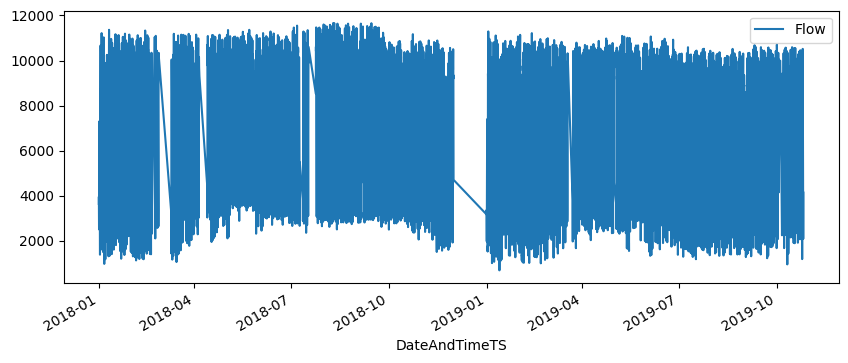

In [15]:
data2.plot(figsize=(10,4))

As a side note, you can add pan/zoom functionality to your plots by installing the `ipympl` package (`pip install ipympl`) and adding the line `%matplotlib widget` to your code:

``` python 
%matplotlib widget
plt.figure(figsize=(10,4))
plt.plot(data2,'.-')
plt.grid()
```
Here is what we see if we then zoom in to the plot:

<img src="f1.png" />

We can also pass in the x and y limits to pandas' plot method. Notice below that the x-limits can be conveniently specified as dates (this is one of those aformentioned feature).

<Axes: xlabel='DateAndTimeTS'>

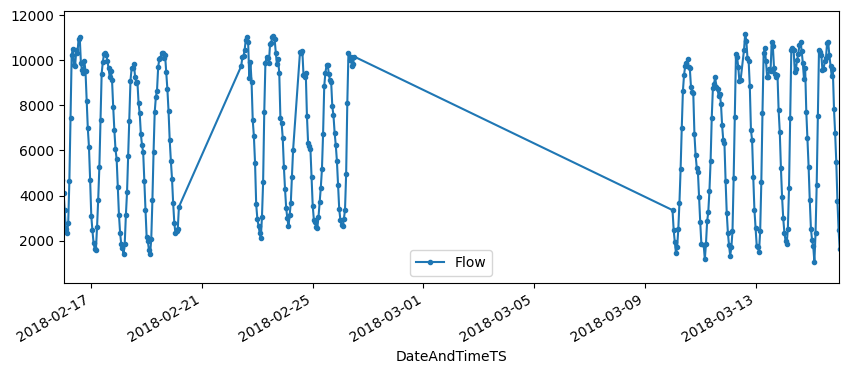

In [16]:
data2.plot(figsize=(10,4),
           xlim=('2018-02-16','2018-03-16'),
           style='.-')

There are indeed quite a few days missing in February and March 2018. If these gaps were small, we might consider filling them with linear interpolation -- effectively filling in the above plot with round markers along the long lines. However this would likely confuse the model-training procedure. Instead we will simply ignore these gaps. The model-training procedure will still be confused by the suddem jumps in the flow, however perhaps less than with interpolation. 

# 4. Training and testing datasets

We will use 80\% of the data for training and 20\% for testing. The dataset has 13,980 hourly samples. Since we are building a time-series forecasting model, it is important that the test dataset follow the training dataset in time. Create a training dataset (`data_train`) by selecting the first 11,184 samples (`ind_split`) from `data2`, and a testing dataset with the remaining samples. 

**Hint**: [`data2.iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html)

In [17]:
Nraw = data2.shape[0]
train_portion = 0.8
ind_split = int(0.8*Nraw)
print(Nraw, ind_split)

13980 11184


In [18]:
data_train = data2.iloc[:ind_split]
data_test = data2.iloc[ind_split:]

In [19]:
grader.check("q4")

q4 results: All test cases passed!

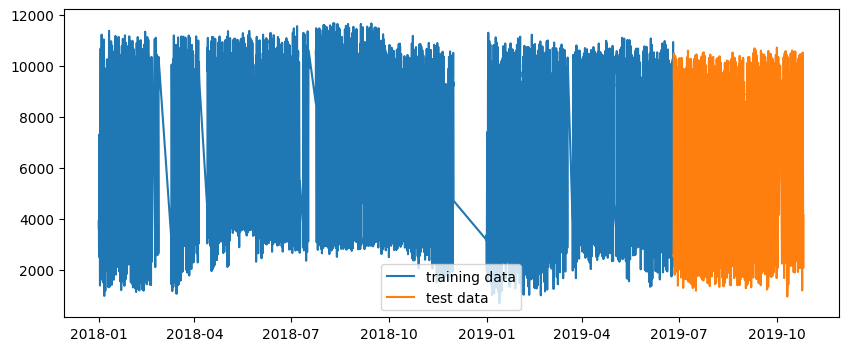

In [20]:
plt.figure(figsize=(10,4))
plt.plot(data_train,label='training data')
plt.plot(data_test,label='test data')
plt.legend()

# 5. Normalize the data

The performance of neural network models is typically enhanced by normalizing the inputs and outputs. We will use scikit-learn's `StandardScaler` to do this. 

When preprocessing data, such as we are doing now, it is important that the test data be treated identically to the training data. This means that the same scaling factors should be applied to the test data samples as were applied to the training data. This was achieved in lab 5 with scikit-learn's `Pipeline` object. Here we will achieve the same by scaling the test data with `StandardScaler` that was fit using the training data.

**Hint** The `fit` and `transform` methods of the `StandardScaler` must receive a matrix-like object -- that is, one with two dimensions. This means that we must add an empty dimension to our one-dimensional flow vector. To acheive this, you can use the `reshape` method as follows:

`data_train['Flow'].values.reshape(-1, 1)`

In [21]:
scaler = StandardScaler()
scaler.fit(data_train['Flow'].values.reshape(-1, 1))
data_train_scaled = scaler.transform(data_train['Flow'].values.reshape(-1, 1))
data_test_scaled = scaler.transform(data_test['Flow'].values.reshape(-1, 1))

In [22]:
grader.check("q5")

q5 results: All test cases passed!

# 6. Organize the data into past and future snippets of flow values.

Write a function that recevies a scaled dataset `d` (`data_train_scaled` or `data_test_scaled`) and creates inputs and output matrices `X` and `y` suitable for model training.

The figure below provides an illustration. Each sample $(x_i,y_i)$ consists of `Np=6` hours of "past" data in $x_i$ and `Nf=24` hours of "future" data in $y_i$. If the input sequence `d` has length `L`, then there will be `N=L-Np-Nf` such samples. Hence the dimensions of `X` and `y` should be `(N,Nh)` and `(N,Nf)` respectively.

<img src='f2.png' />

In [23]:
Np = 6
Nf = 24

def make_samples(d):

    L = d.shape[0]
    N = L - Np - Nf 

    X = np.empty((N,Np))
    y = np.empty((N,Nf))

    for i in range(N):
        X[i,:] = d[i:i+Np,0]
        y[i,:] = d[i+Np:i+Np+Nf,0]

    return X, y

In [24]:
Xtrain, ytrain = make_samples(data_train_scaled)
Xtest, ytest = make_samples(data_test_scaled)

Xtest.shape, ytest.shape

((2766, 6), (2766, 24))

In [25]:
grader.check("q6")

q6 results: All test cases passed!

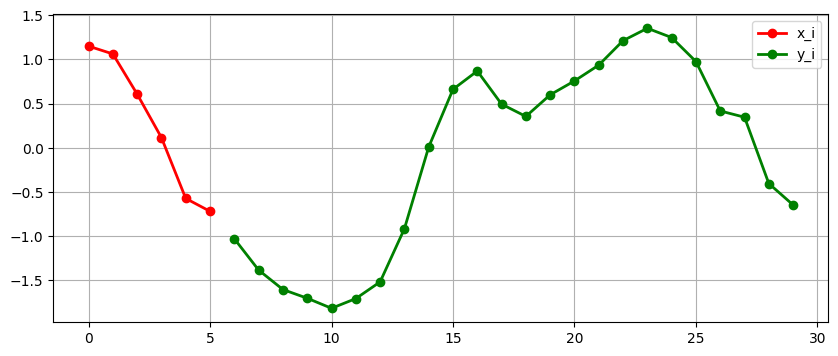

In [26]:
i = 40

plt.figure(figsize=(10,4))
plt.plot(np.arange(0,Np),Xtrain[i],'ro-',linewidth=2,label='x_i')
plt.plot(np.arange(Np,Np+Nf),ytrain[i],'go-',linewidth=2,label='y_i')
plt.legend()
plt.grid(':')

# 7. Add an empty dimension to the training and test datasets to satisfy a Tensorflow requirement

In [27]:
Xtrain_e = Xtrain[:,:,np.newaxis]
ytrain_e = ytrain[:,:,np.newaxis]
Xtest_e = Xtest[:,:,np.newaxis]
ytest_e = ytest[:,:,np.newaxis]

In [28]:
grader.check("q7")

q7 results: All test cases passed!

# 8. Train a dense neural network

A schematic of our model is shown below.

<img src='f3.png'>

The model has a single dense hidden layer with 5 neurons (a.k.a. "units") and a `relu` activation function. The output layer has `Nf=24` units -- one  for each of the outputs of the model. Keras requires that we add a `Flatten()` layer to process the input (I'm not sure why). The final model code looks like this:

``` python
model_dense = Sequential([
    Flatten(),
    Dense(5, activation="relu"),
    Dense(Nf)
])
```

Enter this code in the cell below.

In [29]:

# Create a new Sequential model
model_dense = Sequential()

# Add the layers manually
model_dense.add(Flatten())
model_dense.add(Dense(units=5, activation='relu'))
model_dense.add(Dense(units=24, activation='linear'))


In [30]:

grader.check("q8")



q8 results: All test cases passed!

Next we compile and train this model. The compilation step was not required in scikit-learn. It is used in Keras to configure the model object according to the hardware characteristics of the computing environment. For example, it will prepare the model to be trained using GPUs if you have configured Keras to do this and have the appropriate hardware. 

The `compile` method must receive the chosen loss function to be minimized, and the numerical optimization method to use. We will use minimize the mean squared error using the `adam` optimizer (an improved version of stochastic gradient descent).

In [31]:
model_dense.compile(loss="mse",optimizer="adam")

Finally, we train the model using the `fit` function. Similarly to scikit-learn, Keras' `fit` function takes the training data as input. It also requires the number of epochs (iterations through the training dataset) to run. We will train all of our neural network models for 25 epochs. The method returns a logging object that contains the evolution of the loss over the epochs. Save this to `history_dense`

In [32]:
train_epochs = 25
history_dense = model_dense.fit(Xtrain_e, ytrain_e,epochs=train_epochs)

Epoch 1/25

349/349 [==============================] - 1s 1ms/step - loss: 0.7622
Epoch 2/25
349/349 [==============================] - 0s 1ms/step - loss: 0.4003
Epoch 3/25
349/349 [==============================] - 0s 1ms/step - loss: 0.3397
Epoch 4/25
349/349 [==============================] - 0s 1ms/step - loss: 0.3273
Epoch 5/25
349/349 [==============================] - 0s 1ms/step - loss: 0.3204
Epoch 6/25
349/349 [==============================] - 0s 1ms/step - loss: 0.3148
Epoch 7/25
349/349 [==============================] - 0s 1ms/step - loss: 0.3098
Epoch 8/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3052
Epoch 9/25
349/349 [==============================] - 0s 1ms/step - loss: 0.3012
Epoch 10/25
349/349 [==============================] - 0s 1ms/step - loss: 0.2977
Epoch 11/25
349/349 [==============================] - 0s 1ms/step - loss: 0.2946
Epoch 12/25
349/349 [==============================] - 0s 1ms/step - loss: 0.2923
Epoch 13/25
349/349 [===

# 9. Train a simple recurrent neural network

Next we will build a neural network with simple recurrent units. The schematic is identical to the one shown in section 8, except that now the units in the hidden layer will be recurrent neurons. In Keras, this is specified as a sequential model with two layers. The `Flatten` layer of the dense network is no longer required. Instead, the first layer is of type `SimpleRNN`. The constructor for `SimpleRNN` takes the number of recurrent units (5) and the shape of the input vector (`input_shape=(Np,1)`). The second layer is the same output layer as was used for the dense network.

```python 
model_simprnn = Sequential([
    SimpleRNN(5,input_shape=(Np,1)),
    Dense(Nf)
])
```
Create this model, then compile and train it with the same arguments as in part 8.


In [33]:
model_simprnn = Sequential([
    SimpleRNN(5, input_shape=(Np,1), activation='relu'),
    Dense(24, activation='linear')
])

model_simprnn.compile(loss="mse",optimizer="adam")
history_simprnn = model_simprnn.fit(Xtrain_e, ytrain_e,epochs=train_epochs)

Epoch 1/25
349/349 [==============================] - 1s 2ms/step - loss: 0.9304
Epoch 2/25
349/349 [==============================] - 1s 2ms/step - loss: 0.6456
Epoch 3/25
349/349 [==============================] - 1s 2ms/step - loss: 0.4770
Epoch 4/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3987
Epoch 5/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3739
Epoch 6/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3620
Epoch 7/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3556
Epoch 8/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3505
Epoch 9/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3469
Epoch 10/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3440
Epoch 11/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3397
Epoch 12/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3371
Epoch 13/25
349/349 [====

In [34]:
grader.check("q9")

q9 results: All test cases passed!

# 10. Train an LSTM neural network

Finally we will create a neural network with LSTM units. The code is identical to the Simple RNN case, except that instad of a `SimpleRNN` layer, we use an `LSTM` layer. Create, compile, and train this model. Save the model to `model_lstm` and its training history to `history_lstm`.

In [35]:
model_lstm = Sequential([
    LSTM(5, input_shape=(Np,1), activation='relu'),
    Dense(24, activation='linear')
])
model_lstm.compile(loss="mse",optimizer="adam")
history_lstm = model_lstm.fit(  Xtrain_e, ytrain_e,epochs=train_epochs)

Epoch 1/25
349/349 [==============================] - 2s 2ms/step - loss: 0.7417
Epoch 2/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3815
Epoch 3/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3338
Epoch 4/25
349/349 [==============================] - 1s 2ms/step - loss: 0.3132
Epoch 5/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2990
Epoch 6/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2900
Epoch 7/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2843
Epoch 8/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2797
Epoch 9/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2768
Epoch 10/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2747
Epoch 11/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2716
Epoch 12/25
349/349 [==============================] - 1s 2ms/step - loss: 0.2703
Epoch 13/25
349/349 [====

In [36]:
grader.check("q10")

q10 results: All test cases passed!

# 11. Forecast

Use the `predict` method of the model objects to generate forecasts for the test data. The input to this function is the "extended" version of the testing data `Xtest_e`. 

In [37]:
yhat_dense   = model_dense.predict(Xtest_e)
yhat_simprnn = model_simprnn.predict(Xtest_e)
yhat_lstm    = model_lstm.predict(Xtest_e)

87/87 [==============================] - 0s 1ms/step


In [38]:
grader.check("q11")

q11 results: All test cases passed!

# 12. Plots

### 12.1 Training histories

The loss after each of the training epochs is contained in the history object, and is plotted below. Notice that the LSTM model concludes the training with the lowest loss value, while the dense and Simple RNN models have similar values of final training loss. 

Text(0, 0.5, 'Training MSE')

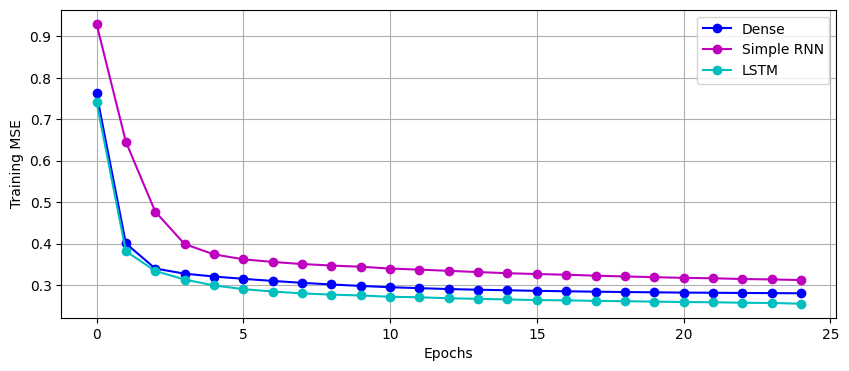

In [39]:
plt.figure(figsize=(10,4))
plt.plot(history_dense.history['loss'], 'bo-',label='Dense')
plt.plot(history_simprnn.history['loss'], 'mo-',label='Simple RNN')
plt.plot(history_lstm.history['loss'], 'co-',label='LSTM')
plt.legend()
plt.grid(':')
plt.xlabel('Epochs')
plt.ylabel('Training MSE')

### 12.2. A sample prediction

To plot the forecast, we will first use the `scaler` object to return the data to its original scale (in vehicles per hour, or vph).

In [40]:
Xtest_vph = scaler.inverse_transform(Xtest)
ytest_vph = scaler.inverse_transform(ytest)
yhat_dense_vph = scaler.inverse_transform(yhat_dense)
yhat_simprnn_vph = scaler.inverse_transform(yhat_simprnn)
yhat_lstm_vph = scaler.inverse_transform(yhat_lstm)

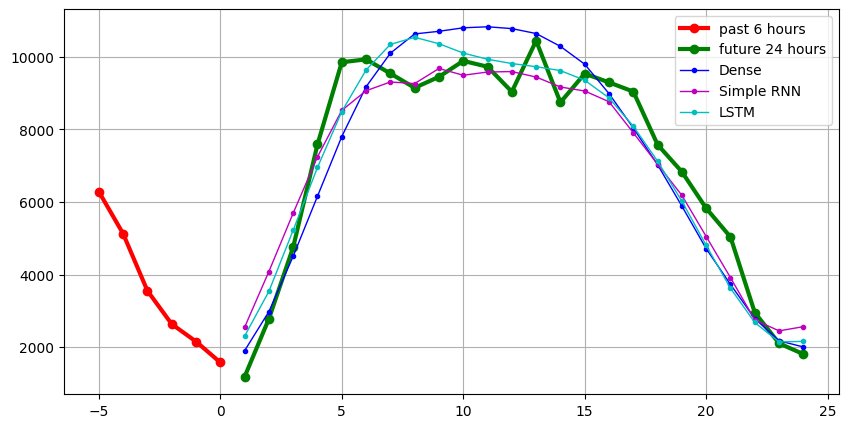

In [41]:
i=500
tx = np.arange(-Np,0)+1
ty = np.arange(Nf)+1

fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(tx,Xtest_vph[i],'ro-', lw = 3,label='past 6 hours') 
ax.plot(ty,ytest_vph[i] ,'go-', lw = 3,label='future 24 hours') 
ax.plot(ty,yhat_dense_vph[i],'bo-', markersize=3, lw = 1, label='Dense') 
ax.plot(ty,yhat_simprnn_vph[i],'mo-', markersize=3, lw = 1, label='Simple RNN') 
ax.plot(ty,yhat_lstm_vph[i],'co-', markersize=3, lw =1, label='LSTM') 
ax.grid(':')
ax.legend()

# 13. Compute performance

We measure the performance of the models with their mean absolute errors. Write a function that computes the MAE between two arrays. Apply it to the unscaled versions of the three model predictions and the test outputs.

In [53]:

def compute_mae(yhat,ytest):
    N=yhat.shape[0]
    return np.mean(np.abs((ytest - yhat) / ytest))

In [54]:
mae_dense = compute_mae(yhat_dense,ytest_vph)
mae_simprnn = compute_mae(yhat_simprnn_vph,ytest_vph)
mae_lstm = compute_mae(yhat_lstm_vph,ytest_vph)

mae_dense, mae_simprnn, mae_lstm

(1.0000951592274245, 0.3290296037267954, 0.27722620549462224)

In [55]:
grader.check("q13")

q13 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [45]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)